In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
import torch
import collections
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
BOX_PATH = "/content/drive/MyDrive/data/train_bboxes.npy"
IMAGE_PATH = "/content/drive/MyDrive/data/train_X.npy"
LABEL_PATH = "/content/drive/MyDrive/data/train_Y.npy"
SEGMENT_PATH = "/content/drive/MyDrive/data/train_seg.npy"

train_boxes = np.load(BOX_PATH)
train_segments = np.load(SEGMENT_PATH).reshape(55000, 64, 64)
train_images = np.load(IMAGE_PATH)
train_labels = np.load(LABEL_PATH)

In [9]:
for i in range(5000):
  mask_file = str(i) + "_mask.png"
  image_file = str(i) + ".png"
  img = Image.fromarray(train_images[i].reshape((64,64,3)), 'RGB')
  img.save(os.path.join("/content/drive/MyDrive/mnist segment/image/", image_file))
  img = Image.fromarray(train_segments[i].reshape((64,64)))
  img.save(os.path.join("/content/drive/MyDrive/mnist segment/mask/", mask_file))

In [2]:
BOX_PATH = "/content/drive/MyDrive/data/valid_bboxes.npy"
IMAGE_PATH = "/content/drive/MyDrive/data/valid_X.npy"
LABEL_PATH = "/content/drive/MyDrive/data/valid_Y.npy"
SEGMENT_PATH = "/content/drive/MyDrive/data/valid_seg.npy"

val_boxes = np.load(BOX_PATH)
val_segments = np.load(SEGMENT_PATH).reshape(5000, 64, 64)
val_images = np.load(IMAGE_PATH)
val_labels = np.load(LABEL_PATH)

In [3]:
for i in range(5000):
  mask_file = str(i) + "_mask.png"
  image_file = str(i) + ".png"
  img = Image.fromarray(val_images[i].reshape((64,64,3)), 'RGB')
  img.save(os.path.join("/content/drive/MyDrive/mnist segment valid/image/", image_file))
  img = Image.fromarray(val_segments[i].reshape((64,64)))
  img.save(os.path.join("/content/drive/MyDrive/mnist segment valid/mask/", mask_file))

In [62]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask"))))

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "image", self.imgs[idx])
        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[:-1]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        boxes = masks_to_boxes(masks)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [63]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 10

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [64]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


backbone.out_channels = 1280


anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2,
)

model = FasterRCNN(
    backbone,
    num_classes=10,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
)

In [65]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [66]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [67]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [68]:
from engine import train_one_epoch, evaluate
import utils
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 10
dataset = MNISTDataset('/content/drive/MyDrive/mnist segment', get_transform(train=True))
dataset_test = MNISTDataset('/content/drive/MyDrive/mnist segment valid', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()



Epoch: [0]  [   0/1119]  eta: 0:12:03  lr: 0.000010  loss: 3.5410 (3.5410)  loss_classifier: 2.2861 (2.2861)  loss_box_reg: 0.0276 (0.0276)  loss_mask: 0.8891 (0.8891)  loss_objectness: 0.3016 (0.3016)  loss_rpn_box_reg: 0.0367 (0.0367)  time: 0.6466  data: 0.2012  max mem: 2166
Epoch: [0]  [ 100/1119]  eta: 0:07:08  lr: 0.000509  loss: 0.8835 (1.2667)  loss_classifier: 0.1529 (0.4254)  loss_box_reg: 0.1229 (0.0873)  loss_mask: 0.5782 (0.6589)  loss_objectness: 0.0222 (0.0761)  loss_rpn_box_reg: 0.0104 (0.0190)  time: 0.4188  data: 0.0096  max mem: 2335
Epoch: [0]  [ 200/1119]  eta: 0:06:24  lr: 0.001009  loss: 0.9045 (1.1224)  loss_classifier: 0.1476 (0.2936)  loss_box_reg: 0.1479 (0.1260)  loss_mask: 0.5784 (0.6334)  loss_objectness: 0.0191 (0.0548)  loss_rpn_box_reg: 0.0054 (0.0147)  time: 0.4105  data: 0.0064  max mem: 2335
Epoch: [0]  [ 300/1119]  eta: 0:05:45  lr: 0.001508  loss: 1.0756 (1.0898)  loss_classifier: 0.2052 (0.2579)  loss_box_reg: 0.2205 (0.1507)  loss_mask: 0.6291 (

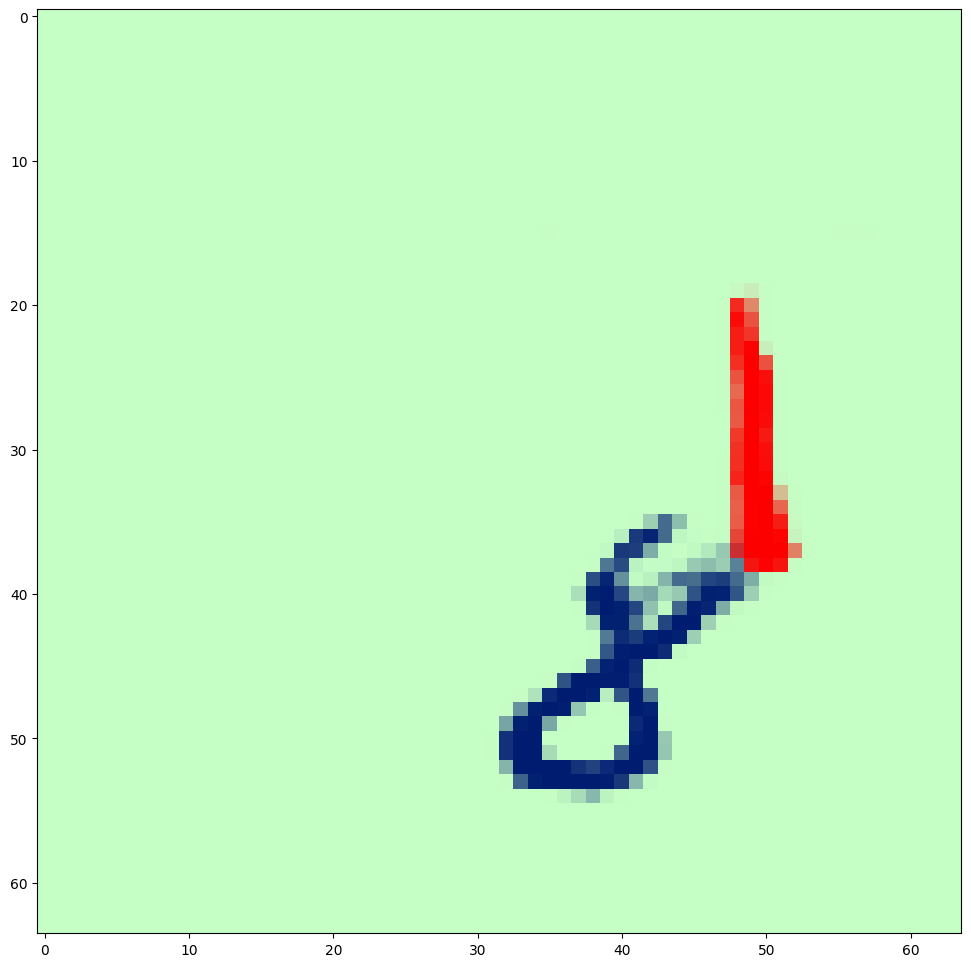

In [69]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("/content/drive/MyDrive/mnist segment valid/image/1.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x.to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]


masks = (pred["masks"] > 0.9).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.0, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))